In [5]:
!pip install transformers
import re
import spacy
from collections import defaultdict, Counter
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import matplotlib.pyplot as plt
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [13]:
df = pd.read_csv('IMDB Dataset.csv')

In [9]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
df_no_duplicates = df.drop_duplicates()
df = df_no_duplicates
print(df.describe())

                                                   review sentiment
count                                               49582     49582
unique                                              49582         2
top     One of the other reviewers has mentioned that ...  positive
freq                                                    1     24884


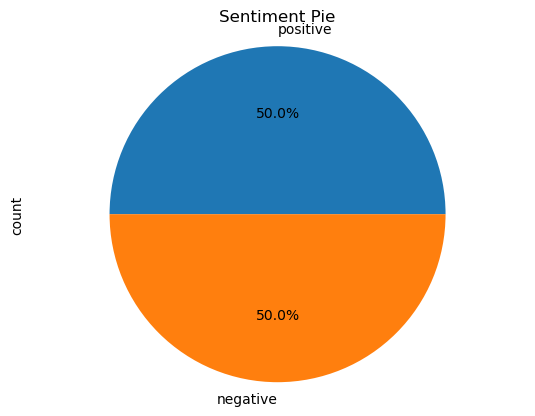

In [15]:
import matplotlib.pyplot as plt

df['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Sentiment Pie')
plt.axis('equal') 
plt.show()

In [17]:
print(df.isnull().sum())

review       0
sentiment    0
dtype: int64


This is to check if we have any null values

In [19]:
df['review'] = df['review'].str.lower()
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


In [21]:
import re

def remove_html_tags(text):
    
    cleaned_text = re.sub(r'<br\s*/*>', ' ', text)
    cleaned_text = re.sub(r'<.*?>', '', cleaned_text)
    
    return cleaned_text


df['review'] = df['review'].apply(remove_html_tags)



In [23]:

df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming t...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


We removed html tags to get pure words, and now we see punctuation marks, now we aim to remove that.

In [25]:
import string
df['review'] = df['review'].str.translate(str.maketrans('', '', string.punctuation))
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming te...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


In [27]:
def extract_characters_and_descriptors(text):
    doc = nlp(text)
    characters = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    descriptors = [token.text for token in doc if token.pos_ == 'ADJ']
    return characters, descriptors


In [29]:
def extract_movie_themes(text):
    doc = nlp(text)
    potential_titles = [ent.text for ent in doc.ents if ent.label_ in ['WORK_OF_ART', 'EVENT']]



By this step we extract keywords like movie names, charecters etc.

In [31]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
     "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [33]:
def chat_conversion(text):
    new_text = []
    for i in text.split():
        if i.upper() in chat_words:
            new_text.append(chat_words[i.upper()])
        else:
            new_text.append(i)
    return " ".join(new_text)


df['review'] = df['review'].apply(chat_conversion)
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend Te...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the Tears in my eyes of...,positive


In [35]:
from sklearn.preprocessing import LabelEncoder
df['sentiment'] = LabelEncoder().fit_transform(df['sentiment'])
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend Te...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the Tears in my eyes of...,1
...,...,...
49995,i thought this movie did a down right good job...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,i am a catholic taught in parochial elementary...,0
49998,im going to have to disagree with the previous...,0


In [37]:
from sklearn.model_selection import train_test_split
X=df["review"]
Y=df["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X,Y)
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37500 entries, 23683 to 27307
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     37500 non-null  object
 1   sentiment  37500 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 732.4+ KB


In [39]:
from sklearn.model_selection import train_test_split
X=df["review"]
Y=df["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X,Y)
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37500 entries, 7016 to 1221
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     37500 non-null  object
 1   sentiment  37500 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 732.4+ KB


In [41]:
VALIDATION_SPLIT=0.2
 
train_size = len(df_train)
df_train = df_train.iloc[:round(train_size * (1 - VALIDATION_SPLIT))]
df_validation = df_train.iloc[-round(train_size * VALIDATION_SPLIT):]

In [43]:
print("No of train data set samples: ",len(df_train))
print("Number of validation data set samples: ",len(df_validation))

No of train data set samples:  30000
Number of validation data set samples:  7500


In [47]:
!pip install tensorflow_hub
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
    --------------------------------------- 0.0/1.7 MB 1.3 MB/s eta 0:00:02
    --------------------------------------- 0.0/1.7 MB 495.5 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.7 MB 901.1 kB/s eta 0:00:02
   ---- ----------------------------------- 0.2/1.7 MB 1.1 MB/s eta 0:00:02
   ------ --------------------------------- 0.3/1.7 MB 1.2 MB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.7 MB 1.2 MB/s eta 0:00:02
   ---------- ----------------------------- 0.4/1.7 MB 1.4 MB/s eta 0:00:01
   ------------ --------------------------- 0.5/1.7 MB 1.5 MB/s eta 0:00:01
   ------------- -------------------------- 0.6/1.7 MB 1.4 MB/s eta 0:00:01
   -------------- ------------------------- 0.6/1.7 MB 1.4 MB/s eta 0:00:01
   --------------- ------------------------ 0.7/1.7 MB 1.3 MB/s eta 0:00:01
   ----------

ModuleNotFoundError: No module named 'tensorflow_text'

In [66]:
!pip install --upgrade tensorflow tensorflow-hub


Defaulting to user installation because normal site-packages is not writeable


This SavedModel implements the encoder API for text embeddings with transformer encoders. It expects a dict with three int32 Tensors as input: input_word_ids, input_mask, and input_type_ids.

In [80]:
LOAD_PREPROCESS_URL ="https://www.kaggle.com/models/tensorflow/bert/frameworks/tensorFlow2/variations/en-uncased-preprocess/versions/3?tfhub-redirect=true"

In [78]:
LOAD_ENCODER_URL = "https://www.kaggle.com/models/tensorflow/bert/frameworks/tensorFlow2/variations/en-uncased-l-12-h-768-a-12/versions/4?tfhub-redirect=true"

In [82]:
BERT_PREPROCESS = hub.KerasLayer(LOAD_PREPROCESS_URL, name='bert-preprocess')
BERT_ENCODER = hub.KerasLayer(LOAD_ENCODER_URL, name='bert-encoding')

RuntimeError: Op type not registered 'CaseFoldUTF8' in binary running on LAPTOP-08B5I6VO. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib (e.g. `tf.contrib.resampler`), accessing should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.

In [86]:
from keras.layers import Layer
def encode_text(texts, tokenizer: Layer, encoder: Layer, encoder_key: str = "sequence_output"):
    embeddings = []
    input_ids = tokenizer(texts)
    outputs = encoder(input_ids)
    embeddings.append(outputs[encoder_key])
    return tf.concat(embeddings, axis=0)

In [94]:
import math

class TextEncoderDataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df: pd.DataFrame, column_text: str,
                 tokenizer: Layer,
                 encoder: Layer,
                 column_label: str = None,
                 batch_size: int = None,
                 shuffle: bool = True,
                 encoder_key: str = "sequence_output"):
        self.data = df.copy()
        self.text_column = column_text
        self.text = self.data[self.text_column].values
        self.label_column = column_label
        if self.label_column is not None:
            self.label = self.data[self.label_column].values
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.tokenizer = tokenizer
        self.encoder = encoder
        self.encoder_key = encoder_key
        self.on_epoch_end()
def __len__(self):
        if self.batch_size is None:
            return len(self.data)
        return math.ceil(len(self.text) / self.batch_size)

def __getitem__(self, index):
        if self.batch_size is None:
            batch_text=self.text
        else:
             batch_text = self.text[index * self.batch_size: (index + 1) * self.batch_size]
        encoded_batch = encode_text(batch_text, tokenizer=self.tokenizer,
                                    encoder_key=self.encoder_key,
                                    encoder=self.encoder)
        if self.label_column is None:
            return encoded_batch
        if self.batch_size is None:
            batch_labels=self.label
        else:
            batch_labels = self.label[index * self.batch_size: (index + 1) * self.batch_size]
        batch_labels = batch_labels.reshape(-1, 1)
        return encoded_batch, batch_labels
def on_epoch_end(self):
        if self.shuffle:
            self.data = self.data.sample(frac=1)
            self.text = self.data[self.text_column].values
            if self.label_column is not None:
                self.label = self.data[self.label_column].values

In [96]:
BATCH_SIZE=256

def get_generator(df, predict_mode=False):
    if predict_mode:
        column_label = None
        shuffle=False
    else:
        shuffle=True
        column_label = 'sentiment'
    return TextEncoderDataGenerator(df, column_text='review',
                                    tokenizer=BERT_PREPROCESS,
                                    encoder=BERT_ENCODER,
                                    column_label=column_label,
                                    shuffle=shuffle,
                                    batch_size=BATCH_SIZE)

In [98]:
train_generator = get_generator(df_train)
validation_generator = get_generator(df_validation)

NameError: name 'BERT_PREPROCESS' is not defined

In [100]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding,Input
def lstm_model(batch_size=BATCH_SIZE,input_shape=(128,768)):
    input_1 = Input( name="input_1",batch_size=batch_size,shape=input_shape)
    lstm_1=LSTM(units=128, return_sequences=True,recurrent_dropout = 0.25 , dropout = 0.25, name="lstm_1")(input_1)
    lstm_2=LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1,name="lstm_2")(lstm_1)
    dense_1 = Dense(units=128, activation='relu', name="dense_1")(lstm_2)
    output_1 = Dense(units = 1, activation='sigmoid',name="output_1")(dense_1)
    model = tf.keras.Model(inputs=[input_1], outputs=[output_1], name="bert-lstm")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [102]:
model = lstm_model()
model.summary()

Model: "bert-lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)                 │ (256, 128, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (256, 128, 128)             │         459,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (256, 64)                   │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (256, 128)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_1 (Dense)                     │ (256, 1)                    │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 517,121 (1.97 MB)

 Trainable params: 517,121 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
EPOCHS = 15
history = model.fit(x=train_generator, validation_data=validation_generator, epochs=EPOCHS)

NameError: name 'train_generator' is not defined

In [108]:
import matplotlib.pyplot as plt
def plot_model_history(model, history,nb_epochs):
    epochs = [i for i in range(nb_epochs)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(16,9)

    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy for model '+model.name)
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss for the model '+model.name)
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    plt.show()

In [110]:
plot_model_history(model, history,EPOCHS)

NameError: name 'history' is not defined